# TP Observations Nocturnes - LU3PY232
**ARGUELLO Camilo**

In [165]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [123]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits
from astropy.visualization import astropy_mpl_style
plt.style.use(astropy_mpl_style)
from utils import pc2m, m2pc, dms2deg, deg2dms, flux2mag, mag2flux, distance_modulus, apparent_to_absolute_flux
from constants import ConstantesAstro
from matplotlib.colors import LogNorm
from astropy.stats import sigma_clip
import os 
import glob
#import astroalign as aa
from photutils.aperture import aperture_photometry, CircularAperture
from photutils.centroids import centroid_quadratic
import processing as  pr
import utils
from IPython.display import display, Math

## 1. Introduction et Contexte

### Objectifs du TP

Ce TP vise à étudier la relation d’échelle entre la taille et la luminosité des galaxies de l’univers proche. 
Nous allons utiliser des images obtenues à l'aide de télescopes à distance pour :

- Calibrer des images photométriques (offset, flat field),
- Extraire des informations scientifiques (taille, luminosité),
- Comparer les résultats avec les théories d’assemblage galactique.


### Diversité morphologique des galaxies

Les galaxies dans l'univers présentent une diversité morphologique remarcable. Dans la literature, on trouve qu'elles sont classifiées selon la séquence de Hubble, où on peut remarquer quelques groupes: 

- **Les galaxies elliptiques**, avec une forme ovoïde. [XX]
- **Les galaxies spirales**, comme par exemple notre Voie Lactée, possèdent un disque aplati avec des bras spiraux où se concentre la formation stellaire, entourant un bulbe central plus dense. [XX]
- **Les galaxies irrégulières**, qui ne montren pas une structure définie, et qui sont souvent le résultat d'interactions gravitationnelles.

Dans ce TP on se concentrerà sur celles **elliptiques** et **spirales**.

### Loi d'échelle taille-luminosité

$$R_e \propto L^\alpha$$

//  explication des relations taille-masse et leur interprétation physique


### Messier 83
// TODO

## 2. Prise en main et visualisation des images

Pour ce TP on est intéressés pour obtenir des informations par rapport des galaxies observables depuis le centre d'observation *Siding Spring Observatory (SSO)* en Australie (GMT+10). Pour ce faire on utilisera plusieurs outils:

- Dans un premier temps, on planifiera une observation sur la plateforme Astrometrique.net pour connaitre à partir d'une centre d'observation et sur une période donnée les possibles galaxies à observer. Y compris le temps d'exposition et l'heure de passage.
- En suite, nous allons obtenir faire une demande d'observation sur la plateforme [itelescope.net](https://itelescope.net). On choisira d'abord un Telescope, selon la disponibilité. Parmi les telescopes les plus utilises chez eux, nous allons utiliser le T17, le T32, et le T33. Pour cela on creera un script qui contiendra l'information par rapport la galaxie a observer, les binings et un temps d'exposition d'environ 300s. Cet outil permet aussi d'obtenir des observations sur une gamme differentes de filtres, on se concentrera sur les filtres rouge, bleu et vert qui nous donnent beaucoup plus de données.

- Ces informations on pourra les traiter après à l'aide de logiciel DS9, ainsi que avec du python et sa bibliothèque `photoutils` et `astrophy`.
- Pour rendre le TP plus facile à lire, on guardera toutes les fonctions crées dans le fichier `utils.py` et `processing.py`.

On commence dans un premiers temps à faire l'analyse pour les données recoltes par rapport la galaxie M83, un gallaxie assez connue et quie est observable depuis le SSO en Australie. On pourra donc dans la premier partie du TP, repondre aux questions avec ces données.

> Quel est l’ordre de grandeur de la brillance de surface des etoiles ?  la brillance de surface du fond de ciel ? La brillance de surface de la galaxie ? En quelle unit´e est le flux sur ces images non-calibrées ?

Dans le logiciel DS9, on mesure à la main les valeurs pour une région définie. Cette approach permettre d'obtenir la valeur moyenne. 

On choisi une zone et on fait deux ou trois mesures, avec l'outil: `X`, qui permet choisir une région en particulière puis obtenir la moyenne. Le tableau 1. montre les valeours obtenues. On a fait les mesures que pour le filtre rouge des images prises pour la galaxie M83. Le tableau avec toutes les mesures peut se trouver dans les appendices de cette rapport. $\small{TODO}$

| Zone     | Brillance de surface   |
|----------|------------------------|
| Étoiles  | $\approx 600 - 2500 $ |
| Fond de ciel  |  $\approx 600 - 700 $  |
| Galaxie  | $\approx 700 - 2300 $  |

$ \small{\text{Tableau 1. Grandeur de brillance selon la zone}} $



> Quelle est la durée de la pose ? Quelle était la date d’observation ?

Les fichiers *.fit sont très utilisés pour stocker une quantitée élevée d'information. Ils peuvent enregistrer des images, mais aussi des tableaux. Ces fichiers permet d'obtenir un `HEADER` ou (entête) et un `BODY` avec l'ensemble des données stockés. `HEADER` va nous permettre d'obtenir les valeurs de la durée de pose, ainsi que la date d'observation.

```ts
EXPTIME =   140.00000000000000 /Exposure time in seconds
DATE-OBS= '2023-05-09T11:32:42.84' /YYYY-MM-DDThh:mm:ss observation, UT
```

> Que pouvez-vous dire de la qualité de cette image ? Quelle est la valeur typique du fond de ciel ?

Pour les observations faites de la galaxie M83, on a des images brutes avec une qualitée bonne. Cependant on peut observer des traces dû a des erreurs dans la mesure, ainsi qu'une distribution non uniforme par rapporte le fond de ciel. Les étoiles apparaissent bien ponctuelles et définies, cependant on peut avoir quelques unes un peu saturées.

On fera une première visualisation des données avec la fonction `plot_initial_filter_sequence` pour afficher dans l'ensemble de filtres disponibles pour M83.

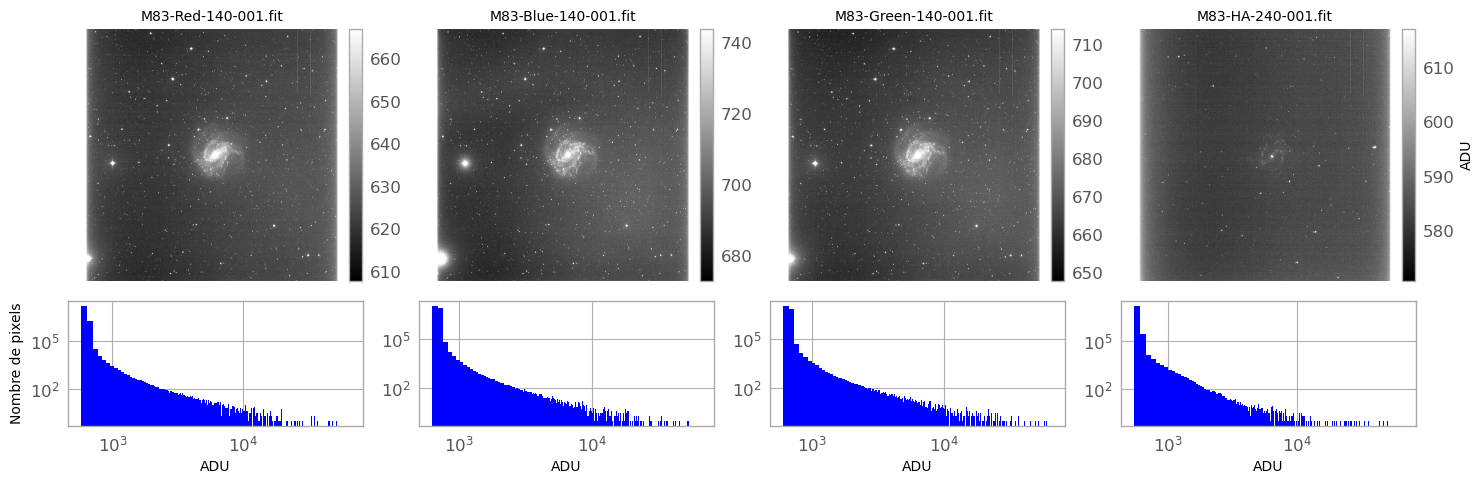

In [25]:
utils.plot_initial_filter_sequence()

In [ ]:
fond_ciel = tab[100:200, 100:200]  # Un petit carré dans une région vide
print(fond_ciel.mean()) # ADU

> Répondez aux mêmes questions avec une image dans un autre filtre. Que constatez vous ? Faites bien attention à prendre en compte le temps de pose lorsque vous comparez les flux.

> Convertissez la taille d’un pixel sur l’image en secondes d’arc puis en kiloparsecs, sachant la distance de cette galaxie (se référer au fichier excel TP 2025 galaxies.xlsx). Justifiez. En le mesurant “à la main”, quel est le rayon caractéristique ce cette galaxie, en `kpc` ?

In [19]:
# M83 
# Telescope: T32 dans l'observatoire SSO en Australie.
FOCALLEN = 2912            # distance focale en mm
XPIXSZ = 9e-3              # taille du pixel en mm (9 microns)
distance_mpc = 4.66        # distance depuis la Terre en Mpc
angular_size_arcsec = 600  # taille angulaire mesurée en arcsec

# Calcul du plate scale théorique (en arcsec par pixel)
pixel_size = utils.get_pixel_size(XPIXSZ, FOCALLEN)  # arcsec / pixel
print(f"Pixel size théorique : {pixel_size:.3f} arcsec/pixel")

physical_size_pc, physical_size_kpc = utils.get_physical_size(angular_size_arcsec, distance_mpc)
print(f"Taille physique de la galaxie : {physical_size_pc:.2f} pc ({physical_size_kpc:.2f} kpc)")

Pixel size théorique : 0.637 arcsec/pixel
Taille physique de la galaxie : 13555.39 pc (13.56 kpc)


## 3. Calibration des images

Qu’apprend-on ? Vérifiez en particulier le temps d’exposition et la taille de l’image

### Construction de la pose maitre d’offset

Affichez l’histogramme des valeurs des pixels. Autour de quelle valeur se trouvel’offset piédestal ?

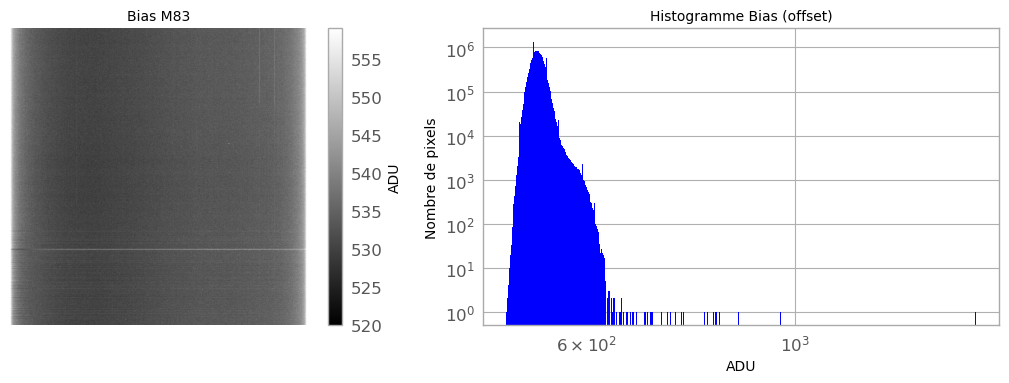

In [23]:
utils.plot_bias_hist('Bias/T32-fetedelascience-Bias-000-LD20230411-LT152814-BIN1.fit', 'M83')

In [ ]:
output_dir = "./Processed/"
list_bias_name = glob.glob('./Bias/*.fit')
sigma = 5
master_bias, master_bias_name, master_bias_no_sigma = pr.master_bias(list_bias_name, out_dir=output_dir, 
                                              out_name='masterbias.fits', overwrite=1, sigma=sigma, out_master_bias_no_sigma='masterbias_no_sigma.fits')

il y a 13 poses de bias dans la liste
le master bias a été sauvé en ./Processed/masterbias.fits
le master bias sans sigma a été sauvé en masterbias_no_sigma.fits


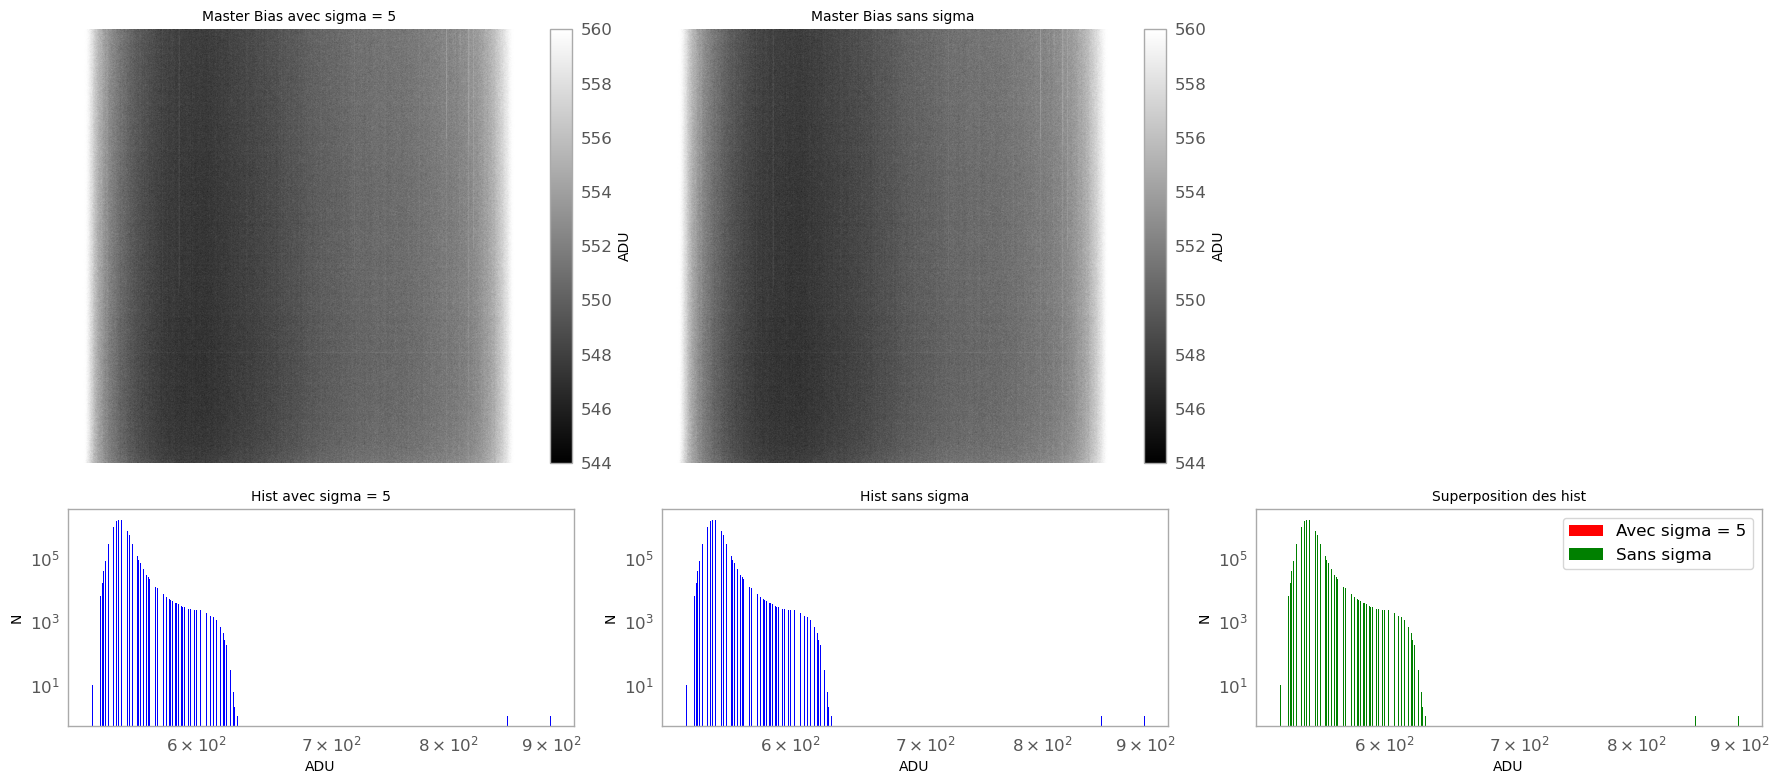

In [77]:
files = [
    ('Processed/masterbias.fits', 'Master Bias avec sigma = ', True),
    ('Processed/masterbias_no_sigma.fits', 'Master Bias sans sigma', False)
]

utils.plot_bias_hist_sigma_stack(files, 5)

In [45]:
# Charger une pose individuelle (exemple de la première image)
bias_example = fits.getdata(list_bias_name[0])

print("---- Pose individuelle ----")
print(f"Moyenne : {np.mean(bias_example):.2f}")
print(f"Ecart-type : {np.std(bias_example):.2f}")

print("---- Master Bias ----")
print(f"Moyenne : {np.mean(master_bias):.2f}")
print(f"Ecart-type : {np.std(master_bias):.2f}")

---- Pose individuelle ----
Moyenne : 555.11
Ecart-type : 9.05
---- Master Bias ----
Moyenne : 551.03
Ecart-type : 5.90


## 4. Pipeline de traitement

In [ ]:

# Ouvrir une image brute et l'image finale
image_brute = fits.getdata('./M83/M83-Blue-140-001.fit')
image_finale = fits.getdata('./Processed/M83_Blue_final_calibrated.fits')

print("--- Pose individuelle ---")
print(f"Moyenne : {np.mean(image_brute):.2f}")
print(f"Ecart-type : {np.std(image_brute):.2f}")

print("--- Image finale stackée ---")
print(f"Moyenne : {np.mean(image_finale):.2f}")
print(f"Ecart-type : {np.std(image_finale):.2f}")

pattern ./M83/M83-Red-*.fit
Trouvé 5 fichiers pour le filtre Red.
--- Pose individuelle ---
M83 Image brute : Moyenne : 627.93 ADU, Ecart-type : 259.41
--- Image finale stackée ---
M83 Image finale: Moyenne : 1.03 ADU, Ecart-type : 2.72


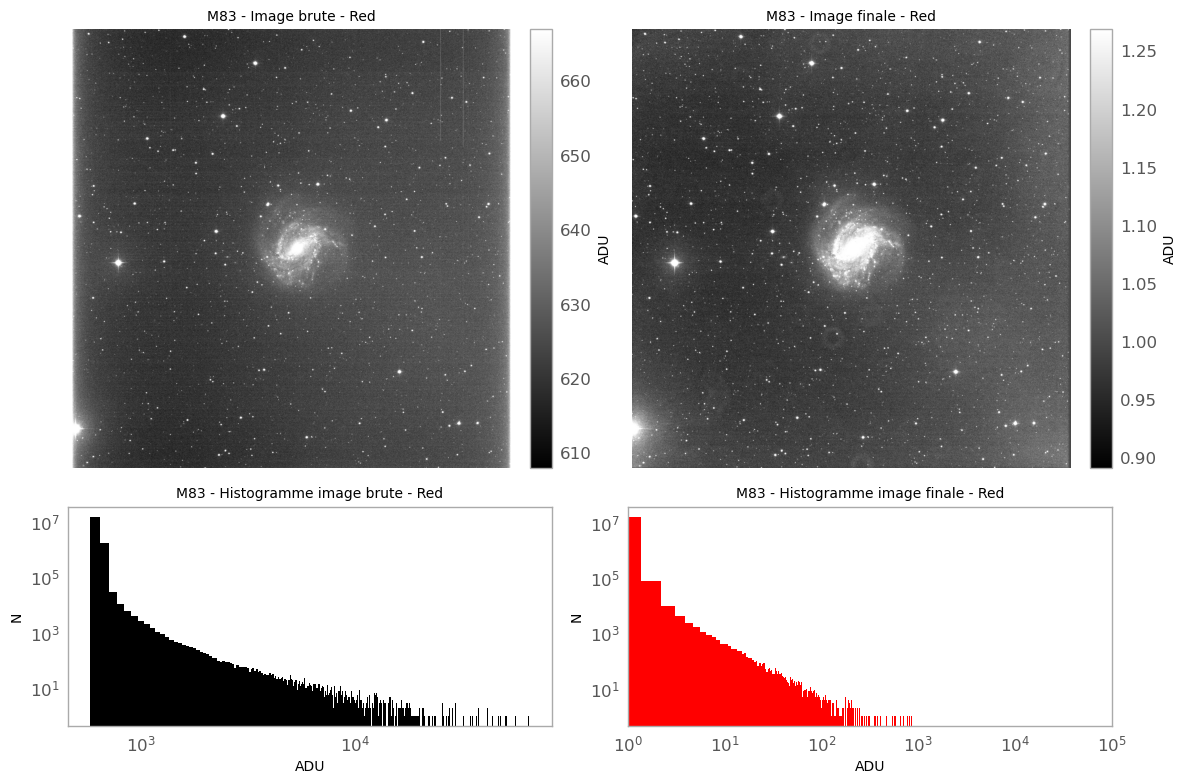

In [85]:
props = {
    'galaxy_name': 'M83',
    'input_folder': './M83/',
    'bias_path': './Processed/masterbias.fits',
    'flat_folder': './flats_maitre/',
    'output_folder': './Processed/',
    'color_init': 'black',
    'os': os
}
utils.plot_images_and_histograms({ **props, 'filter_name': 'Red', 'color_final': 'red',})

pattern ./M83/M83-Blue-*.fit
Trouvé 5 fichiers pour le filtre Blue.
--- Pose individuelle ---
M83 Image brute : Moyenne : 697.71 ADU, Ecart-type : 287.47
--- Image finale stackée ---
M83 Image finale: Moyenne : 1.02 ADU, Ecart-type : 1.98


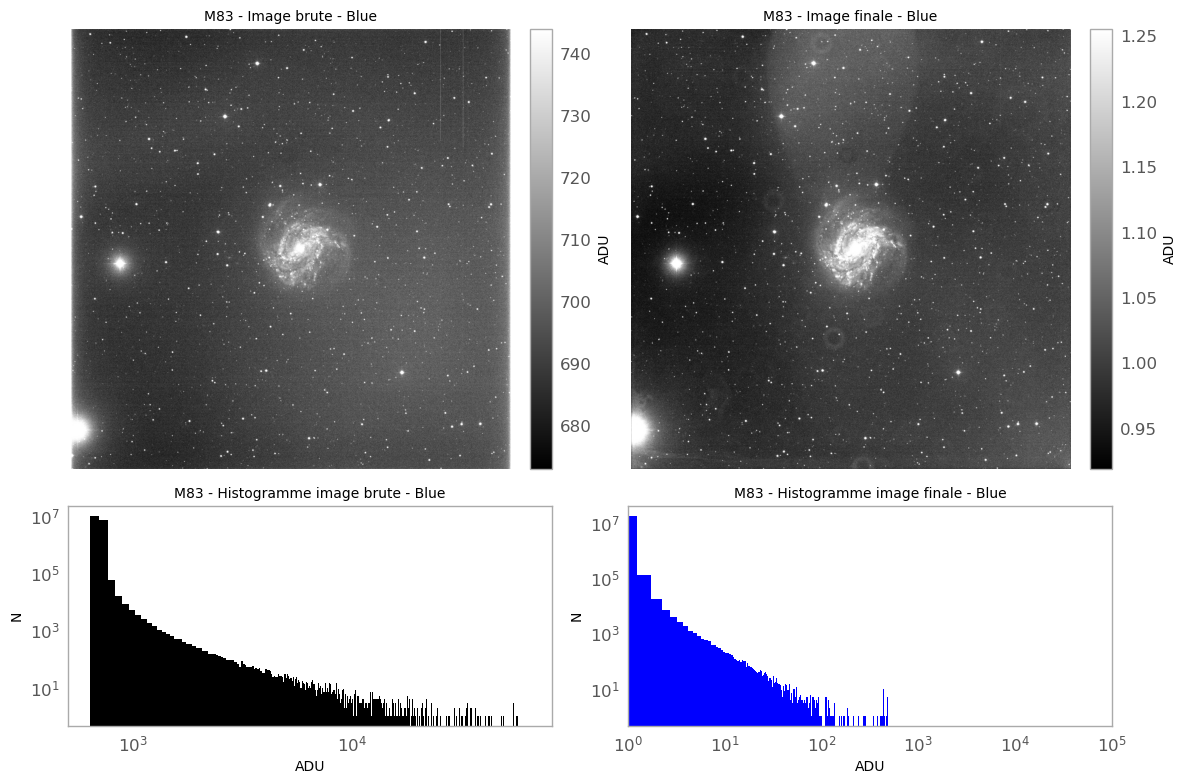

In [86]:
utils.plot_images_and_histograms({ **props, 'filter_name': 'Blue', 'color_final': 'blue'})

pattern ./M83/M83-Green-*.fit
Trouvé 5 fichiers pour le filtre Green.
--- Pose individuelle ---
M83 Image brute : Moyenne : 670.85 ADU, Ecart-type : 287.33
--- Image finale stackée ---
M83 Image finale: Moyenne : 1.03 ADU, Ecart-type : 2.45


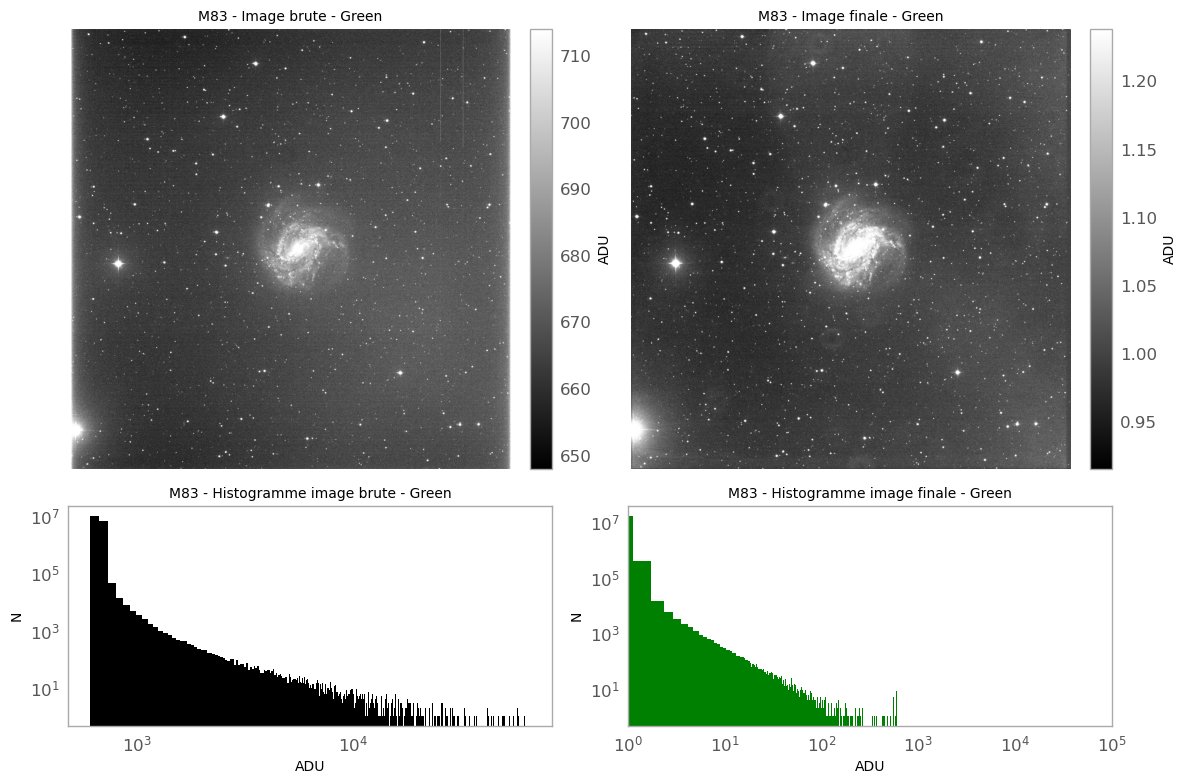

In [87]:
utils.plot_images_and_histograms({ **props, 'filter_name': 'Green', 'color_final': 'green' })

## 5. Photométrie : taille et luminosité

In [91]:
pixel_size_kpc = utils.get_pixel_size_in_kpc(pixel_size, distance_mpc) # kpc/pixel
print(f"Taille du pixel : {pixel_size_kpc:.3f} kpc/pixel")

Taille du pixel : 0.014 kpc/pixel


<string>:45: RuntimeWarning: divide by zero encountered in log10
<string>:63: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


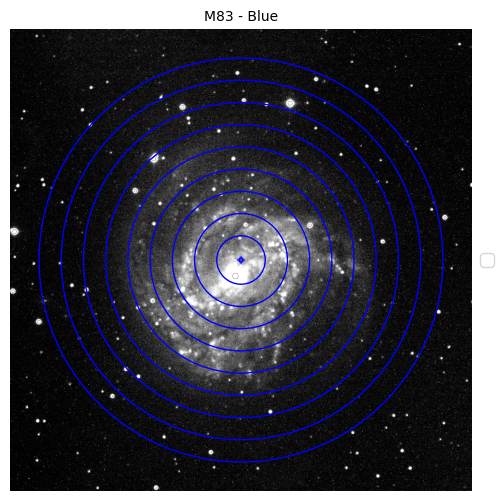

In [100]:
image_calibrated = utils.get_image_calibrated('./Processed/M83_Blue_final_calibrated.fits')
rad_list = np.linspace(0.1,10,10)
flux_list, bckg = utils.return_flux(image_calibrated,rad_list,pixel_size_kpc,search_center=True,rm_background=True,diagnostic=True, galaxy_name='M83', filter_name='Blue', color='blue')

In [101]:
lum,rad,rad_tot = utils.size_luminosity(rad_list,flux_list)
print('lum = ',lum)
print('rad = ',rad)
print('rad_tot = ',rad_tot)

lum =  [92774.93542889]
rad =  [4.5]
rad_tot =  [10.]


In [ ]:
zero_point = 19.05 # ZP for M83 with the T32 telescope

Magnitude AB =  [15.21746322  9.29270672  8.24099644  7.6155636   7.2563141   6.99051344
  6.82694404  6.73415505  6.67147083  6.63142335]


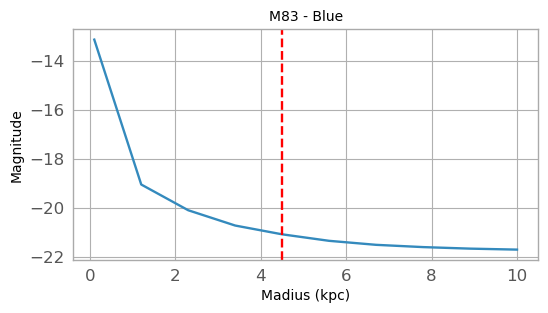

In [140]:
magnitudes = utils.calculate_magnitudes(flux_list, distance_mpc, rad_list, rad, zero_point)
utils.plot_radial_magnitudes(magnitudes, rad_list, rad, 'M83', 'Blue')

In [134]:
magz_ellipt, reff_ellipt, magz_disk, reff_disk = size_luminosity_data = utils.get_size_luminosity_data()

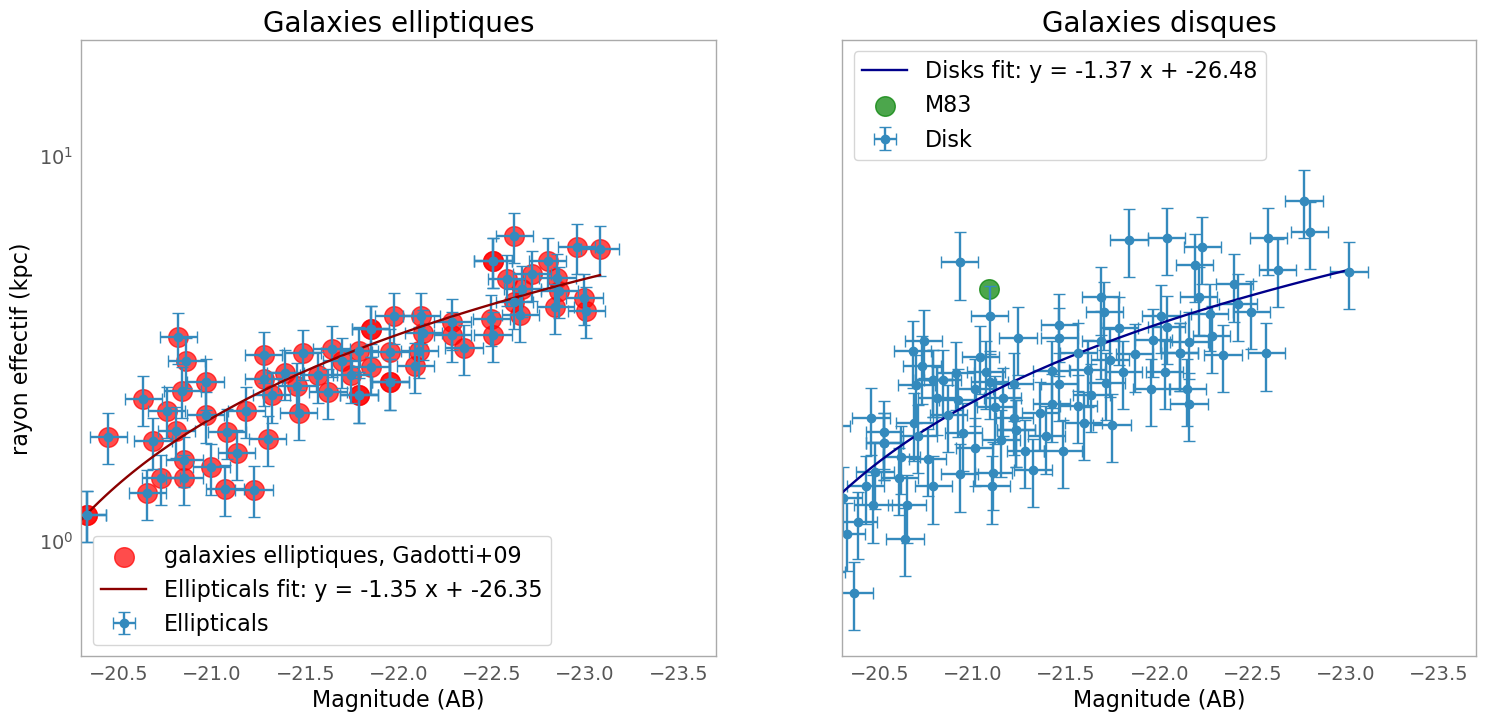

In [166]:
# ---- Linear fit for Elliptical Galaxies ----
coeffs_ell = np.polyfit(magz_ellipt, reff_ellipt, 1)
fit_ell = np.polyval(coeffs_ell, magz_ellipt)
# Estimate the scatter (standard deviation of residuals)
sigma_ell = np.std(reff_ellipt - fit_ell)

# ---- Linear fit for Disk Galaxies ----
coeffs_disk = np.polyfit(magz_disk, reff_disk, 1)
fit_disk = np.polyval(coeffs_disk, magz_disk)
sigma_disk = np.std(reff_disk - fit_disk)

# Generate fit lines for plotting
x_fit_ell = np.linspace(magz_ellipt.min(), magz_ellipt.max(), 100)
y_fit_ell = np.polyval(coeffs_ell, x_fit_ell)

x_fit_disk = np.linspace(magz_disk.min(), magz_disk.max(), 100)
y_fit_disk = np.polyval(coeffs_disk, x_fit_disk)

fig, axes = plt.subplots(1,2,figsize = (18,8),sharex=True,sharey=True)

## Panneau de gauche : galaxies elliptiques
ax = axes[0]
#ax.errorbar(magz_ellipt, reff_ellipt, yerr=sigma_ell, fmt='o', markersize=8,
#             color='red', alpha=0.7, label='Ellipticals Data')

magz_err = 0.1  # 0.1 mag uncertainty
reff_err = 0.15 * reff_ellipt  # 15% uncertainty on radius

# Plot with error bars
ax.scatter(magz_ellipt,reff_ellipt,s = 200,alpha=0.7,color='red',label = 'galaxies elliptiques, Gadotti+09')
ax.errorbar(magz_ellipt, reff_ellipt, 
             xerr=magz_err, yerr=reff_err, 
             fmt='o', label='Ellipticals', capsize=4)
# ax.scatter(M_eff,rad, color='green', s=200, alpha=0.7, label='M87 effective radius')
ax.plot(x_fit_ell, y_fit_ell, color='darkred',
         label=f'Ellipticals fit: y = {coeffs_ell[0]:.2f} x + {coeffs_ell[1]:.2f}')

ax.legend(loc = 'lower left', fontsize = 16)
ax.set_xlim(-20,-24)
ax.set_ylim(0.5,20)
ax.set_yscale('log')
ax.set_xlabel('Magnitude (AB)',fontsize=16)
ax.set_ylabel('rayon effectif (kpc)',fontsize=16)
ax.set_title('Galaxies elliptiques',fontsize = 20)
ax.grid()
## Panneau de droite : galaxies disques
ax1 = axes[1]


#x_d = disks["iMAGd"]
#y_d = disks["h"]
magz_err = 0.1
reff_err = 0.2 * reff_disk  # 20% uncertainty on scalelength

ax1.errorbar(magz_disk, reff_disk, 
             xerr=magz_err, yerr=reff_err, 
             fmt='o', label='Disk', capsize=4)
ax1.plot(x_fit_disk, y_fit_disk, color='darkblue',
         label=f'Disks fit: y = {coeffs_disk[0]:.2f} x + {coeffs_disk[1]:.2f}')
# ax1.scatter(magz_disk,reff_disk,color='blue',s = 200,alpha=0.7,label = 'galaxies disques, Gadotti+09')
# Add a point for the M87 galaxy effective radius (rad) and magnitude (mag_tot)
ax1.scatter(magnitudes['effective_magnitude'],rad, color='green', s=200, alpha=0.7, label='M83')
ax1.legend(loc = 'upper left', fontsize = 16)
ax1.set_xlim(-20.3,-23.7)
ax1.set_ylim(0.5,20)
ax1.set_yscale('log')
ax1.set_xlabel('Magnitude (AB)',fontsize=16)
ax1.set_title('Galaxies disques',fontsize = 20)
ax1.grid()
for i in range(2):
    axes[i].tick_params(axis='both', which='major', labelsize=14)
    axes[i].tick_params(axis='both', which='minor', labelsize=14)
plt.show()

In [144]:
from astroquery.vizier import Vizier
import pandas as pd

# Set Vizier row limit (you can change or set to -1 for all available rows)
Vizier.ROW_LIMIT = -1

# Define only the columns we need
columns = [
    "MType", "MType2",  # Morphology
    "gMAGd", "rMAGd", "iMAGd",  # Disk magnitudes
    "gMAGbu", "rMAGbu", "iMAGbu",  # Bulge magnitudes
    "h", "re",  # Disk scalelength and Bulge effective radius
    "Blg/T", "D/T", "Bar/T",  # Component ratios
    "z",  # Redshift
    "(g-i)d", "(g-i)bu"  # Color indices
]

# Load the table: J/MNRAS/393/1531 (Dimitri A. Gadotti 2009)
catalog_id = "J/MNRAS/393/1531"
vizier = Vizier(columns=columns)
result = vizier.get_catalogs(catalog_id)

# The main table is usually the first one
data = result[0].to_pandas()

# Preview the dataframe
print("Total entries:", len(data))
print(data.head())

# Optional: Filter Elliptical vs Disk
# For example: classify "Elliptical" as MType starting with 'E', "Disk" with 'S' or 'Sb' etc.
ellipticals = data[data["MType"].str.startswith("E", na=False)]
disks = data[data["MType"].str.startswith("S", na=False)]

print("Ellipticals:", len(ellipticals))
print("Disks:", len(disks))

Total entries: 50
          MType    MType2  gMAGd      rMAGd      iMAGd     gMAGbu     rMAGbu  \
0     classical  unbarred -19.74 -20.580000 -20.959999 -19.330000 -19.940001   
1     classical  unbarred -20.18 -20.879999 -21.340000 -19.410000 -20.680000   
2  pseudo-bulge  unbarred -20.18 -20.639999 -20.940001 -15.820000 -16.860001   
3    elliptical  unbarred    NaN        NaN        NaN -20.680000 -21.389999   
4    elliptical  unbarred    NaN        NaN        NaN -20.610001 -21.379999   

   iMAGbu      h     re  Blg/T    D/T  Bar/T      z  (g-i)d  (g-i)bu  
0  -20.33  2.103  1.244  0.359  0.641    0.0  0.067   1.222    1.001  
1  -21.27  2.409  1.827  0.483  0.517    0.0  0.047   1.170    1.862  
2  -17.24  2.189  0.523  0.032  0.968    0.0  0.043   0.760    1.421  
3  -21.74    NaN  2.735  1.000  0.000    0.0  0.063     NaN    1.060  
4  -21.83    NaN  3.120  1.000  0.000    0.0  0.056     NaN    1.214  
Ellipticals: 0
Disks: 0


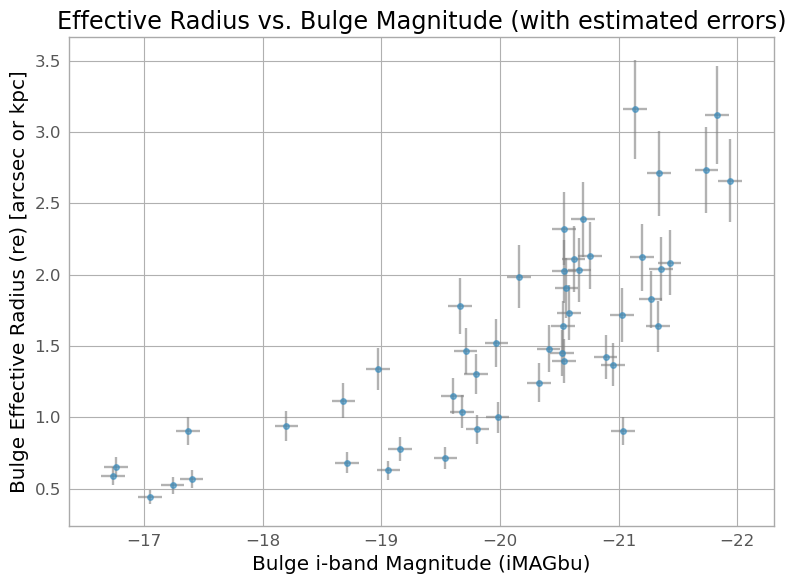

In [167]:
# For demonstration, use bulge effective radius vs. bulge i-band magnitude
x = data["iMAGbu"]
y = data["re"]

# Apply fixed uncertainties (you can refine these based on paper)
xerr = [0.1] * len(x)  # ±0.1 mag
yerr = 0.11 * y         # 20% of the effective radius

plt.errorbar(x, y, xerr=xerr, yerr=yerr, fmt='o', ecolor='gray', alpha=0.6, markersize=4)
plt.gca().invert_xaxis()  # Bright galaxies have lower magnitudes
plt.xlabel("Bulge i-band Magnitude (iMAGbu)")
plt.ylabel("Bulge Effective Radius (re) [arcsec or kpc]")
plt.title("Effective Radius vs. Bulge Magnitude (with estimated errors)")
plt.grid(True)
plt.tight_layout()
plt.show()


In [161]:
magnitudes['effective_magnitude'], rad

(np.float64(-21.08561548374927), array([4.5]))

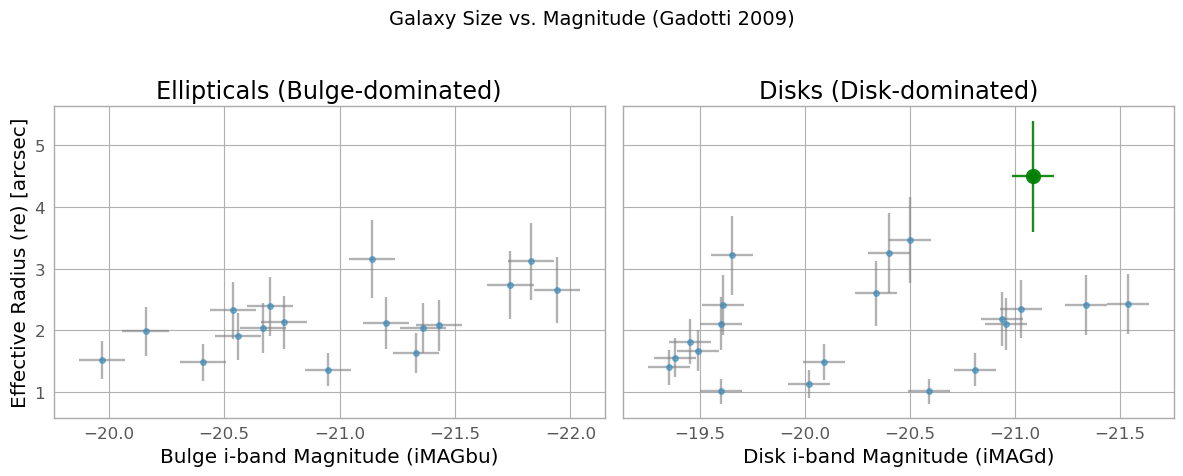

In [162]:
import matplotlib.pyplot as plt

# Ellipticals: use bulge i-band magnitude and bulge effective radius
#ellipticals = data[data["MType"].str.startswith("E", na=False)]
#ellipticals = ellipticals[["iMAGbu", "re"]].dropna()

# Ellipticals
ellipticals = data[data["MType"] == "elliptical"][["iMAGbu", "re"]].dropna()

# Disks – select bulgeless, pseudo-bulge, or classical (depending on your definition)
disks = data[data["MType"].isin(["pseudo-bulge", "classical", "bulgeless"])][["iMAGd", "h"]].dropna()


x_e = ellipticals["iMAGbu"]
y_e = ellipticals["re"]
xerr_e = [0.1] * len(x_e)
yerr_e = 0.2 * y_e  # 20% uncertainty on effective radius

# Disks: use disk i-band magnitude and disk scalelength
# disks = data[data["MType"].str.startswith("S", na=False)]
#disks = disks[["iMAGd", "h"]].dropna()
x_d = disks["iMAGd"]
y_d = disks["h"]
xerr_d = [0.1] * len(x_d)
yerr_d = 0.2 * y_d  # 20% uncertainty on scalelength

# Create side-by-side plots
fig, axs = plt.subplots(1, 2, figsize=(12, 5), sharey=True)

# Plot ellipticals
axs[0].errorbar(x_e, y_e, xerr=xerr_e, yerr=yerr_e, fmt='o', ecolor='gray', alpha=0.6, markersize=4)
axs[0].invert_xaxis()
axs[0].set_title("Ellipticals (Bulge-dominated)")
axs[0].set_xlabel("Bulge i-band Magnitude (iMAGbu)")
axs[0].set_ylabel("Effective Radius (re) [arcsec]")

# Plot disks

axs[1].scatter(magnitudes['effective_magnitude'], rad, color='green', s=100, alpha=0.9, label='M83')
axs[1].errorbar(magnitudes['effective_magnitude'], rad, xerr=[0.1], yerr=[0.2 * rad[0]], fmt='o', color='green', ecolor='green', alpha=0.9)

axs[1].errorbar(x_d, y_d, xerr=xerr_d, yerr=yerr_d, fmt='o', ecolor='gray', alpha=0.6, markersize=4)
axs[1].invert_xaxis()
axs[1].set_title("Disks (Disk-dominated)")
axs[1].set_xlabel("Disk i-band Magnitude (iMAGd)")

plt.suptitle("Galaxy Size vs. Magnitude (Gadotti 2009)", fontsize=14)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()


In [89]:
# 6.2

from astropy.io import fits
import numpy as np
import matplotlib.pyplot as plt
from photutils.aperture import CircularAperture, aperture_photometry

# Charger ton image finale calibrée
image_data = fits.getdata('./Processed/M83_Red_final_calibrated.fits')  # Exemple avec Red

# Définir le centre de la galaxie (à ajuster si besoin)
x_center = 2048
y_center = 2048
positions = [(x_center, y_center)]

# Définir différentes tailles d'ouverture (en pixels)
radii = [50, 100, 150, 200, 250]  # Rayons en pixels

# Faire des mesures d'ouverture
for r in radii:
    aperture = CircularAperture(positions, r=r)
    phot_table = aperture_photometry(image_data, aperture)
    flux = phot_table['aperture_sum'][0]
    print(f"Rayon : {r} pixels → Flux mesuré : {flux:.2f} ADU")


Rayon : 50 pixels → Flux mesuré : 19613.87 ADU
Rayon : 100 pixels → Flux mesuré : 52878.01 ADU
Rayon : 150 pixels → Flux mesuré : 103268.17 ADU
Rayon : 200 pixels → Flux mesuré : 171666.22 ADU
Rayon : 250 pixels → Flux mesuré : 254825.81 ADU


In [ ]:
# Photométrie simple avec photutils
from photutils.aperture import CircularAperture, aperture_photometry

positions = [(x0, y0)]  # centre de la galaxie
radii = [10, 15, 20, 25, 30]  # à adapter

for r in radii:
    aperture = CircularAperture(positions, r=r)
    phot_table = aperture_photometry(stacked_image, aperture)
    print(f"Rayon {r}: flux = {phot_table['aperture_sum']}")

## 6. Étude statistique loi taille-luminosité

In [ ]:
# Exemple de tracé final
luminosities = [...]  # µJy
radii_kpc = [...]     # kpc
types = [...]         # par exemple ["spirale", "elliptique", ...]

plt.scatter(luminosities, radii_kpc, c=type_color_map[types], label=types)
plt.xlabel("Luminosité (µJy)")
plt.ylabel("Rayon effectif (kpc)")
plt.title("Relation taille-luminosité")
plt.legend()
plt.grid()
plt.show()

## 7. Discussion

- Incertitudes principales :
  * fond de ciel
  * étalonnage du point-zéro
  * qualité des poses
- Comportement selon le type morphologique ?
- Alignement avec les résultats de Gadotti (2009) ?